In [141]:
# Calculer le taux de tir moyen par heure par emplacement pour une saison donnée, puis
# visualiser sur une image de demi-glace de hockey
import json
import sys
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns

In [142]:
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

from pipeline.download_data import extract_game_ids

In [143]:
game_ids = extract_game_ids("MTL", 2024)
print(len(game_ids))

87


In [144]:
# Load the hockey rink image
half_rink_image_path = Path("../assets/half_rink.png")
half_rink_image = mpimg.imread(half_rink_image_path)

In [145]:
# Fetching the csv file containing shot events from the 2024-2025 MTL season
shots_data_path = Path("../data/shots_data_MTL_2024_2025.csv")
shots_df = pd.read_csv(shots_data_path)

In [146]:
# Transformation des coordonnées pour centrer sur la demi-glace 
def transform_coordinates(shots_df):
    x0 = shots_df["x_coord"].to_numpy(dtype=float)
    y0 = shots_df["y_coord"].to_numpy(dtype=float)

    mask_right = x0 > 0 

    shots_df["x_coord"] = np.where(mask_right, -x0, x0)
    shots_df["y_coord"] = np.where(mask_right, -y0, y0)

    x_temp = shots_df["x_coord"].copy()
    shots_df["x_coord"] = -shots_df["y_coord"]
    shots_df["y_coord"] = x_temp

    shots_df["y_coord"] = shots_df["y_coord"] - 2.5  # ajuster verticalement pour centrer sur le but

    shots_df["x_coord"] = shots_df["x_coord"].clip(-42.5, 42.5)
    shots_df["y_coord"] = shots_df["y_coord"].clip(-100, 0)


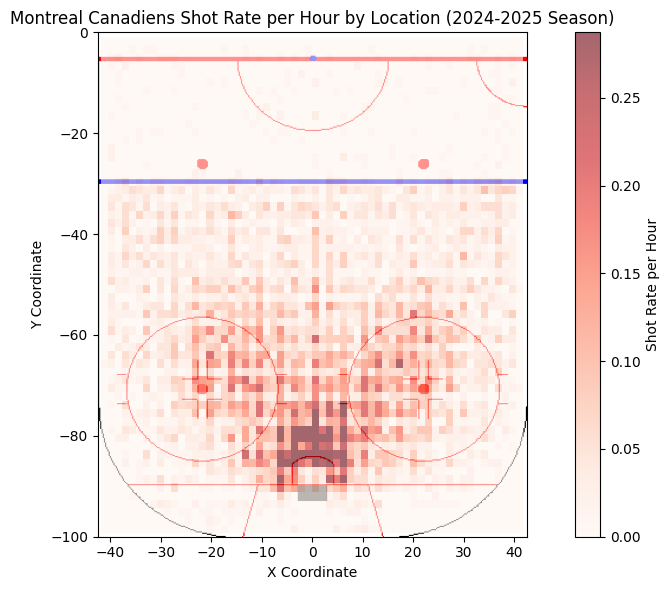

In [147]:
# Visualisation des tirs par saison, sur la même demi-glace

transform_coordinates(shots_df)

# Histogramme 2D sur la demi-glace
bins_x, bins_y = 60, 60
x_range = (-42.5, 42.5)
y_range = (-100, 0)

shot_counts, xedges, yedges = np.histogram2d(
    shots_df["x_coord"],
    shots_df["y_coord"],
    bins=[bins_x, bins_y],
    range=[x_range, y_range],
)

#Taux de tirs par heure
total_game_time_hours = len(game_ids) 
shot_rate_per_hour = shot_counts / total_game_time_hours

# Décalage d'un demi-bin 
dx = (xedges[-1] - xedges[0]) / shot_rate_per_hour.shape[0]
dy = (yedges[-1] - yedges[0]) / shot_rate_per_hour.shape[1]

extent_centered = [
    xedges[0] + dx / 2,
    xedges[-1] - dx / 2,
    yedges[0] + dy / 2,
    yedges[-1] - dy / 2,
]

# Échelle de couleurs stable (évite qu’un outlier écrase tout)
vmax = np.percentile(shot_rate_per_hour, 99)

# Visualisation
fig, ax = plt.subplots(figsize=(10, 6))

# Image de glace 
ax.imshow(
    half_rink_image,
    extent=[x_range[0], x_range[1], y_range[0], y_range[1]],
    origin="lower",
    aspect="equal",
)

# Heatmap
hm = ax.imshow(
    shot_rate_per_hour.T,
    extent=extent_centered,
    origin="lower",
    cmap="Reds",
    alpha=0.6,
    vmin=0,
    vmax=vmax,
    interpolation="nearest", 
)

# Axes verrouillés 
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_aspect("equal", adjustable="box")

cbar = plt.colorbar(hm, ax=ax)
cbar.set_label("Shot Rate per Hour")

ax.set_title("Montreal Canadiens Shot Rate per Hour by Location (2024-2025 Season)")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

plt.tight_layout()
plt.show()

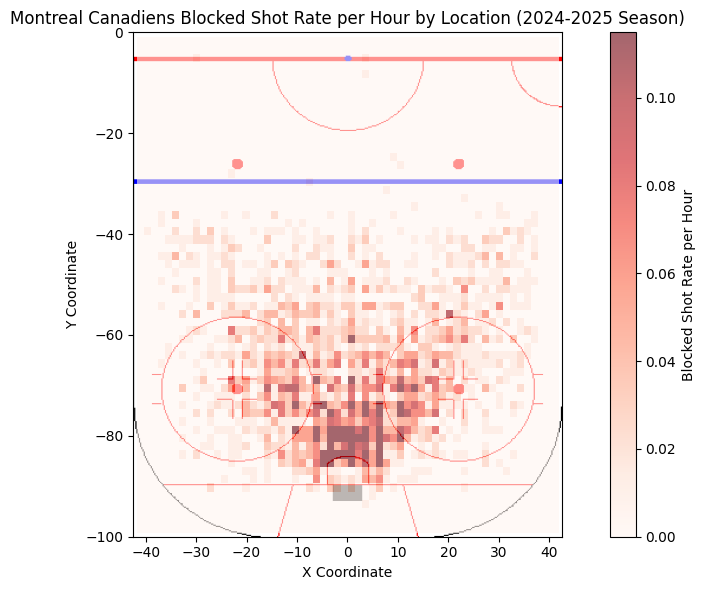

In [148]:
# Visualisation des tirs bloqués par saison, sur la même demi-glace 

# Extraire seulement les blocked-shots du dataframe pandas
blocked_shots_df = shots_df[shots_df["shot_type_desc"] == "blocked-shot"].copy()

# Histogramme 2D sur la demi-glace
bins_x, bins_y = 60, 60
x_range = (-42.5, 42.5)
y_range = (-100, 0)

shot_counts, xedges, yedges = np.histogram2d(
    blocked_shots_df["x_coord"],
    blocked_shots_df["y_coord"],
    bins=[bins_x, bins_y],
    range=[x_range, y_range],
)

#Taux de tirs par heure
total_game_time_hours = len(game_ids) 
shot_rate_per_hour = shot_counts / total_game_time_hours

# Décalage d'un demi-bin 
dx = (xedges[-1] - xedges[0]) / shot_rate_per_hour.shape[0]
dy = (yedges[-1] - yedges[0]) / shot_rate_per_hour.shape[1]

extent_centered = [
    xedges[0] + dx / 2,
    xedges[-1] - dx / 2,
    yedges[0] + dy / 2,
    yedges[-1] - dy / 2,
]

# Échelle de couleurs stable (évite qu’un outlier écrase tout)
vmax = np.percentile(shot_rate_per_hour, 99)

# Visualisation
fig, ax = plt.subplots(figsize=(10, 6))

# Image de glace 
ax.imshow(
    half_rink_image,
    extent=[x_range[0], x_range[1], y_range[0], y_range[1]],
    origin="lower",
    aspect="equal",
)

# Heatmap
hm = ax.imshow(
    shot_rate_per_hour.T,
    extent=extent_centered,
    origin="lower",
    cmap="Reds",
    alpha=0.6,
    vmin=0,
    vmax=vmax,
    interpolation="nearest", 
)

# Axes verrouillés 
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax.set_aspect("equal", adjustable="box")

cbar = plt.colorbar(hm, ax=ax)
cbar.set_label("Blocked Shot Rate per Hour")

ax.set_title("Montreal Canadiens Blocked Shot Rate per Hour by Location (2024-2025 Season)")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

plt.tight_layout()
plt.show()